In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Create a path for output files and plots
if not os.path.exists(output_path + scenario + '/'):
    os.makedirs(output_path + scenario + '/')

In [6]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [7]:
#sm.segments = [('Fz'+str(p), car) for p in [1,2,3,4,6] for car in [0,1]]
sm.segments = ['Fz'+str(p) for p in [1,2,3,4,6]]

In [8]:
volumes_file = 'de_volumes' if len(sm.segments)==5 else 'de_volumes_car_own'
v = stepmodel.read_json(model_path + scenario + '/' + volumes_file)

In [9]:
# Rename columns that were confused through json export
sm.volumes = v.volumes.rename(columns={c: eval(c) for c in v.volumes.columns if c[0]=='('})

In [10]:
road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [11]:
car = stepmodel.read_json(model_path + scenario + '/' + 'de_road_los')
pt = stepmodel.read_json(model_path + scenario + '/' + 'de_pt_los')

In [16]:
# Rename columns that were confused through json export
column_dict = {col: eval(col) if len(sm.segments)==5 else (eval(eval(col)[0]), 'probability')
               for col in pt.pt_los.columns if 'probability' in col}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [17]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [18]:
sm.pt_los.sample(2)

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,path,...,"('Fz1', 'utility')","('Fz2', 'utility')","('Fz3', 'utility')","('Fz4', 'utility')","('Fz6', 'utility')","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
index,,,,,,,,,,,,,,,,,,,,,
234612,1715,NaN,DE947,0,14880,482057,"(rl_1582, rl_1583, rl_1584, rl_1585, rl_3508, ...",2,DE712,NaN,...,-9.153947,-6.060585,-9.950749,-2.611749,-4.580127,0.003251,0.046965,0.006506,0.055980,0.024855
295496,2095,NaN,DE721,86,10860,361025,"(bus_814855, bus_814857, bus_1009665, bus_2916...",5,DE922,NaN,...,-6.823300,-4.720339,-8.495300,-2.611749,-3.981489,0.012618,0.117280,0.012076,0.053783,0.033574


In [19]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

## Assignment

In [20]:
# The current volumes table contains outward and return trips per OD pair.

In [21]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.57s/it]


In [22]:
# Generate road_links loads from car_los and volumes
sm.segmented_car_assignment()

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [01:57<00:00, 23.59s/it]


In [23]:
# Assign volumes to LoS path table
sm.compute_los_volume(keep_segments=True)

## Results

In [24]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,route_type,route_type_disagg,geometry,a,b,link_sequence,route_id,time,trip_id,headway,"(load, bus)","(load, rail)","(load, air)","(load, walk)",load
index,,,,,,,,,,,,,,,
bus_57032,bus,bus,"LINESTRING (8.68047 50.10058, 8.68635 50.09936)",b_DE712_115,b_DE712_213,4,bus_10329,120,bus_10329_0,1728,0.0,6088.029056,0.0,0.0,6088.029056


In [25]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,maxspeed,length,time,geometry,lanes,"(Fz1, car)","(Fz2, car)","(Fz3, car)","(Fz4, car)","(Fz6, car)","(all, car)"
index,,,,,,,,,,,,,
rl_376792,2982002737,1571960354,57,3809,300,"LINESTRING (7.94386 48.22134, 7.98976 48.23680)","[3, 1, 2]",1.370514e+06,201159.450992,1.562578e+06,631105.597672,1.724589e+06,5.489946e+06


In [26]:
sm.los.sample()

,index,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,...,"(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)",Fz1,Fz2,Fz3,Fz4,Fz6,volume
653562,660343,600,NaN,DE143,NaT,19420,498327,"(rl_263058, rl_316788, rl_316768, rl_316765, r...",0,DEA31,...,0.679679,0.966717,0.819526,0.905908,0.0,0.0,0.0,27.044347,242.783224,269.827571


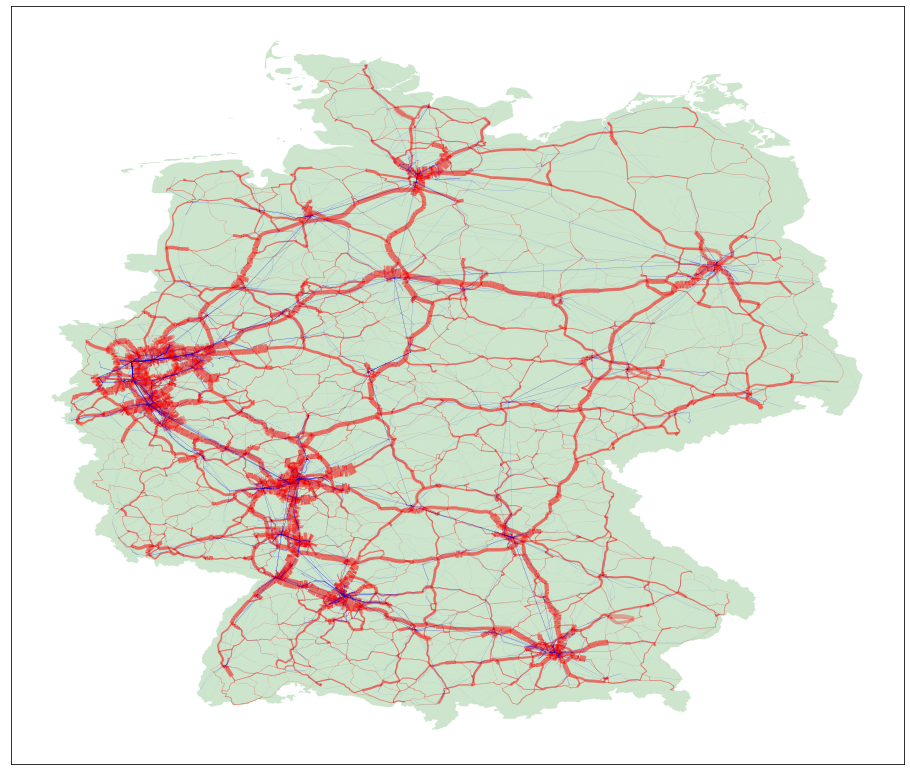

In [27]:
# Plot road and PT assignment
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))
plt.savefig(output_path + scenario + '/' + 'network_load_all.png', dpi=300)

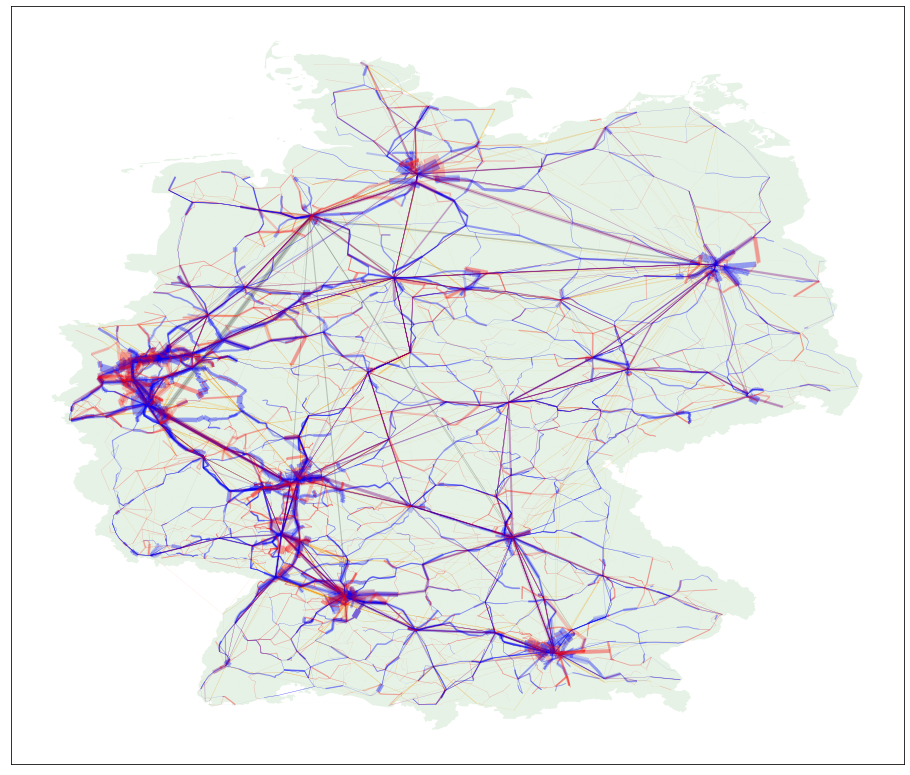

In [28]:
# Only PT
colors = sm.loaded_links['route_type'].map(
    {'rail': 'blue', 'rail_long': 'purple', 'rail_short': 'blue',
     'bus': 'red', 'subway': 'red', 'tram': 'red', 'ferry': 'red', 'funicular': 'red',
     'coach': 'orange', 'air': 'black', 'walk': 'grey'})
sm.loaded_links.plot(alpha=.2, color=list(colors),
    linewidth=list(sm.loaded_links['load']/sm.loaded_links['load'].max()*35),
    ax=sm.plot('zones', alpha=.1, color='green', figsize=(16,16)))
plt.savefig(output_path + scenario + '/' + 'network_load_pt.png', dpi=300)

### Validation

In [29]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

In [30]:
diff['diff'].mean()

2.4115974352549876e-07

<AxesSubplot:>

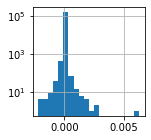

In [31]:
diff['diff'].hist(bins=20, log=True, figsize=(2,2))

In [32]:
# Summary of LoS table volumes
#od_sum = sm.summary_od(costs=[])
od_sum = sm.los.rename(columns={'route_type':'mode'}).groupby(
    ['origin', 'destination', 'mode'])[sm.segments].sum()
if len(sm.segments) > 5:
    for purpose in [seg[0] for seg in sm.segments]:
        od_sum[purpose] = od_sum[[seg for seg in sm.segments if seg[0]==purpose]].sum(axis=1)
    od_sum.drop(sm.segments, axis=1, inplace=True)
od_sum['root'] = od_sum.sum(axis=1)
od_sum.columns = pd.MultiIndex.from_tuples([(c, 'volume') for c in od_sum.columns],
                                           names=['segment', 'sum'])

In [33]:
od_sum.sample()

,,segment,Fz1,Fz2,Fz3,Fz4,Fz6,root
,,sum,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,
DE274,DEA47,car,0.0,0.0,0.0,167.420637,521.417644,688.838281


In [34]:
# Add averages from following attributes
attrs = ['price', # EUR per person
         'time', # hours per trip
         'in_vehicle_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type'])[attrs].mean()
for attr in attrs:
    od_sum[('root', attr)] = means[attr]

In [35]:
# Convert units
od_sum[('root', 'length')] /= 1000
od_sum[('root', 'in_vehicle_time')] /= 3600

In [36]:
# Compute passenger kilometer
purposes = sm.segments if len(sm.segments)==5 else list(dict.fromkeys([seg[0] for seg in sm.segments]))
for seg in purposes + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

In [37]:
# Load calibration dataset for modal split validation
mid2017 = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid2017.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_agg'] = [mode_dict_mid[i] for i in mid2017.index]

array([<AxesSubplot:ylabel='1'>, <AxesSubplot:ylabel='2'>,
       <AxesSubplot:ylabel='3'>, <AxesSubplot:ylabel='4'>,
       <AxesSubplot:ylabel='6'>], dtype=object)

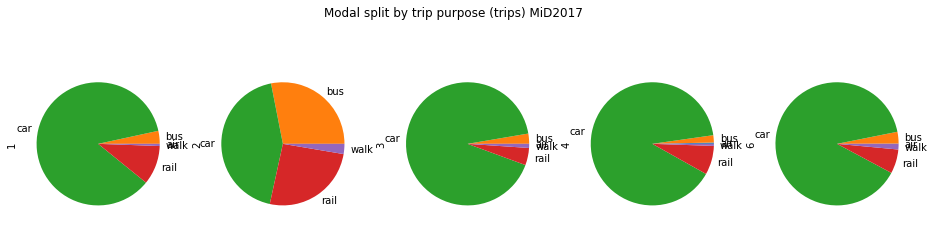

In [38]:
mid2017.groupby('mode_agg').sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

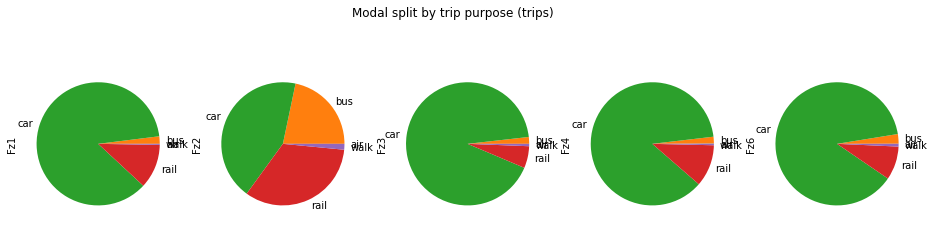

In [39]:
od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
plt.savefig(output_path + scenario + '/' + 'modal_split_trips_segmented.png', dpi=300)

In [40]:
# MiD mode shares in percent
(mid2017.groupby('mode_agg').sum() / mid2017[['1','2','3','4','6']].sum() * 100).round(2)

,1,2,3,4,6
mode_agg,,,,,
air,0.00,0.00,0.01,0.35,0.05
bus,3.40,28.10,2.67,1.90,3.10
car,85.75,43.49,91.72,89.62,89.03
rail,10.28,25.75,4.53,7.59,6.34
walk,0.57,2.66,1.08,0.54,1.48


In [41]:
# Model mode shares in percent
(od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum(axis=1) /
 od_sum[[(seg, 'volume') for seg in purposes]].sum().droplevel('sum') * 100).round(2)

,Fz1,Fz2,Fz3,Fz4,Fz6
mode,,,,,
air,0.00,0.00,0.00,0.09,0.03
bus,1.96,21.70,1.78,1.76,2.52
car,86.12,43.30,91.84,86.76,87.92
rail,11.63,33.47,5.75,11.02,8.82
walk,0.28,1.53,0.62,0.37,0.71


In [ ]:
# MiD2017 mode shares - total
mid2017['sum'] = mid2017[['1','2','3','4','6']].sum(axis=1)
(mid2017.groupby('mode_agg').agg({'sum': 'sum'}) / mid2017['sum'].sum() * 100).round(2)

In [ ]:
# Model mode shares in percent - total
(od_sum['root'].groupby(level=2).sum() / od_sum['root'].sum() * 100).round(2)

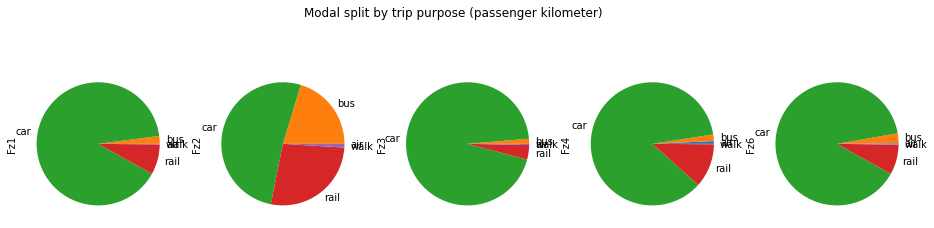

In [42]:
od_sum[[(seg, 'pkm') for seg in purposes]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')
plt.savefig(output_path + scenario + '/' + 'modal_split_pkm_segmented.png', dpi=300)

In [43]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [44]:
# Normalise model volumes
od = od_sum[[(seg, 'volume') for seg in purposes]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od = (od-od.min())/(od.max()-od.min()).max()
# Scale model and validation data to the same level
od = od * (vp2017.mean().mean() / od.mean().mean())

In [45]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 300, 1000]
distances = sm.car_los.drop_duplicates(['origin', 'destination']).set_index(
    ['origin', 'destination'])['length'] / 1000
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [46]:
# Cut matrices into distance classes
od['bins'] = pd.cut(od.merge(distances, how='left', left_index=True, right_index=True)['length'],
                    bins=bins, labels=labels)
vp2017['bins'] = pd.cut(vp2017.merge(distances, how='left', left_index=True, right_index=True)['length'],
                        bins=bins, labels=labels)

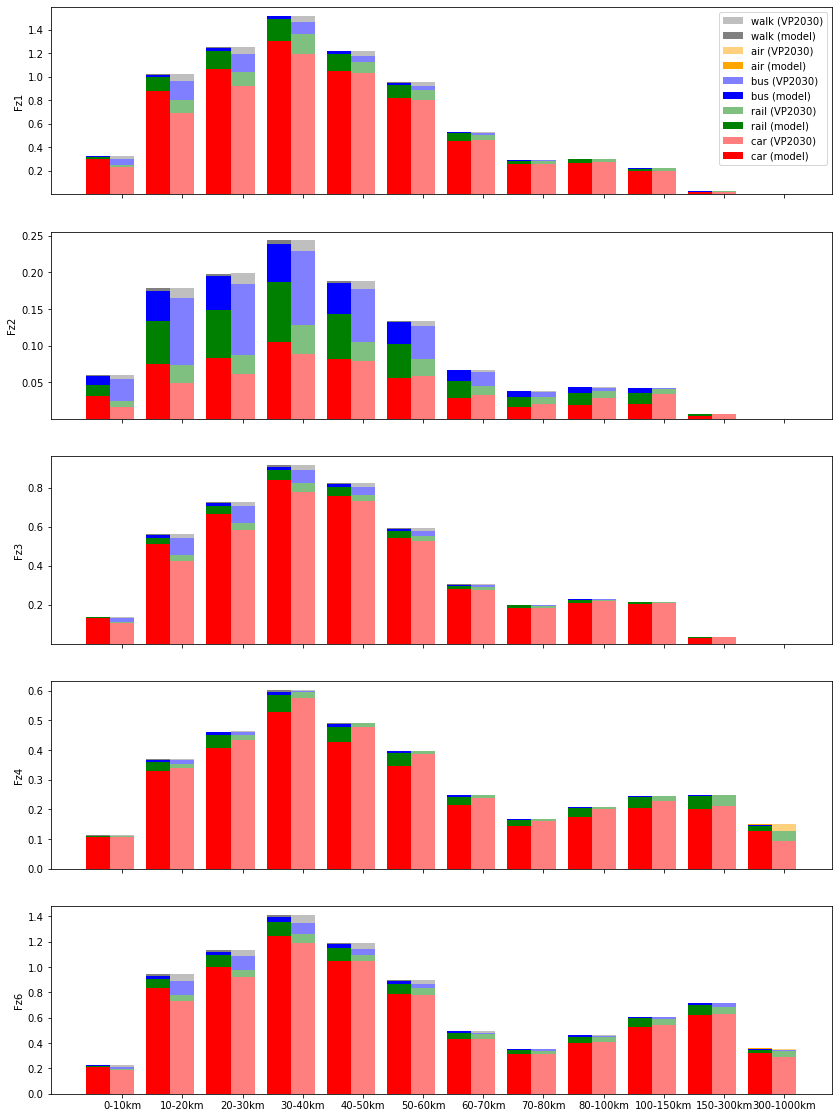

In [47]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
width = 0.4
ind = np.arange(len(labels))
modes = ['car', 'rail', 'bus', 'air', 'walk']
colors = ['red', 'green', 'blue', 'orange', 'grey']
od_binned = od.groupby('bins').sum()
vp_binned = vp2017.groupby('bins').sum()
for seg in range(len(purposes)):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    vp_vols = [vp_binned[(purposes[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            vp_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            vp_bottom = sum(vp_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(vp_vols[i]), bottom=vp_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030.png', dpi=300)

In [48]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
if not str(mid2017.loc[0, 'origin']).startswith('DE'):
    lau_nuts_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
    mid2017['origin'] = mid2017['origin'].astype(str).map(lau_nuts_dict)
    mid2017['destination'] = mid2017['destination'].astype(str).map(lau_nuts_dict)
    # Drop all other trips
    mid2017 = mid2017.loc[(mid2017['origin'].notna()) & (mid2017['destination'].notna())]
# Rename modes and purposes
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_vp'] = 'Fz' + mid2017['purpose_vp'].apply(str)

In [49]:
# Count observations by distance class
mid2017['length'] = mid2017.set_index(['origin', 'destination']).index.map(distances.to_dict())
mid2017['bins'] = pd.cut(mid2017['length'], bins=bins, labels=labels)
mid2017 = mid2017.groupby(['bins', 'mode_model', 'purpose_vp']).count()[
    ['origin']].unstack().unstack().fillna(0).droplevel(0, axis=1)

In [50]:
# Normalise and scale the dataset
mid2017 = (mid2017-mid2017.min())/(mid2017.max()-mid2017.min()).max()
mid2017 = mid2017 * (od_binned.mean().mean() / mid2017.mean().mean())

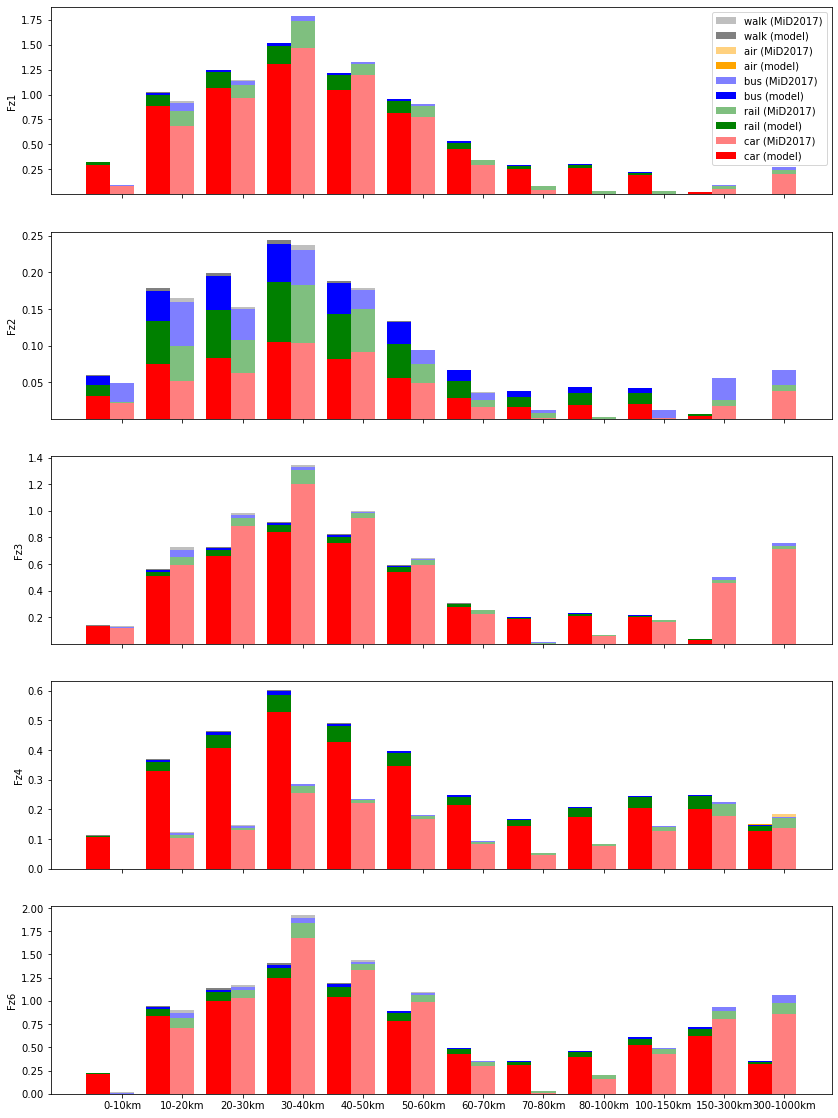

In [51]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
for seg in range(len(purposes)):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    mid_vols = [mid2017[(purposes[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            mid_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(mid_vols[i]), bottom=mid_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017.png', dpi=300)

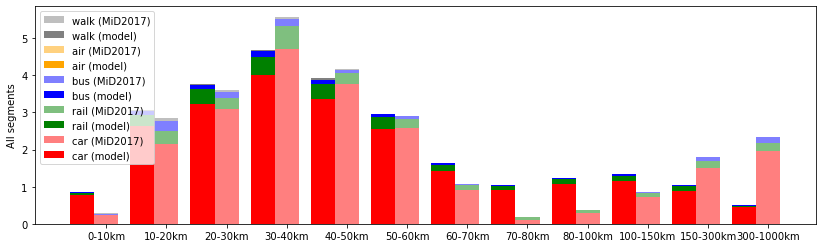

In [52]:
# Plot distance and mode distribution all together
fig, ax = plt.subplots(figsize=(14,4))
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        mid_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
ax.set_ylabel('All segments')
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_all.png', dpi=300)

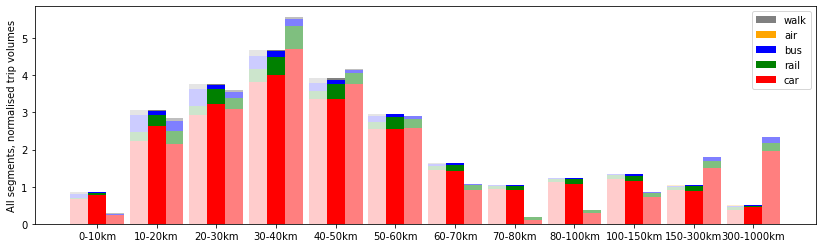

In [53]:
# Plot distance and mode distribution for all three data sources
fig, ax = plt.subplots(figsize=(14,4))
width = 0.3
vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        vp_bottom = 0
        model_bottom = 0
        mid_bottom = 0
    else:
        vp_bottom = sum(vp_vols[:i])
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind-width, vp_vols[i], bottom=vp_bottom, alpha=.2,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i])#+' (model)')
ax.set_ylabel('All segments, normalised trip volumes')
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-3], l[::-3])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_VP2030_all.png', dpi=300)

In [54]:
# Difference in the largest distance segment in % to MiD2017
(sum(model_vols.T[-1]) - sum(mid_vols.T[-1])) / sum(mid_vols.T[-1])

-0.784040275386936

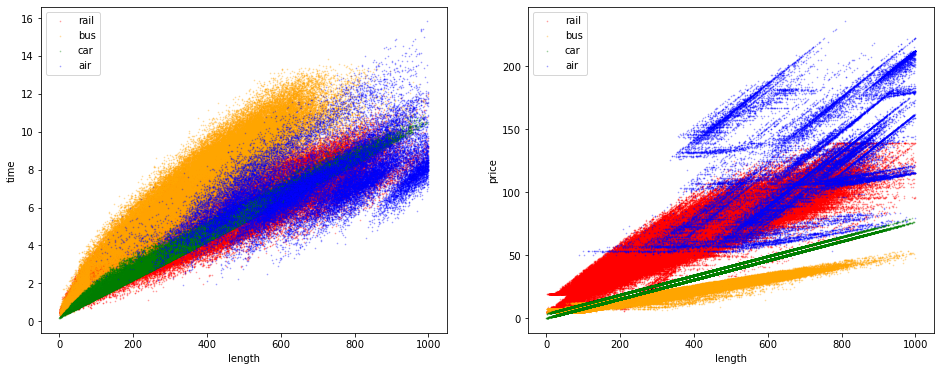

In [55]:
# How do the LoS attributes look like again?
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
c_dict = {'rail': 'red', 'bus': 'orange', 'car': 'green', 'air': 'blue'}
sm.los['length'] = sm.los['length'] / 1000
for m in c_dict.keys():
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[0], kind='scatter', x='length', y='time', s=.5, c=c_dict[m], alpha=.3, label=m)
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[1], kind='scatter', x='length', y='price', s=.5, c=c_dict[m], alpha=.3, label=m)
plt.legend()
plt.savefig(output_path + scenario + '/' + 'LoS_attributes.png', dpi=300)
sm.los['length'] = sm.los['length'] * 1000

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [56]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [57]:
# Aggregated modal split in million pkm by main mode
od.groupby(level=2).sum(axis=1)['pkm'] / 1e6

mode
air       1921.805040
bus      23743.490115
car     797051.877124
rail     76893.778494
walk      2048.273196
Name: pkm, dtype: float64

In [58]:
# Show pkm (mio.) by disaggregated PT modes
if 'length' not in sm.loaded_links.columns:
    sm.loaded_links['length'] = skims.distance_from_geometry(
        sm.loaded_links['geometry']).astype(int)
sm.loaded_links['pkm'] = sm.loaded_links['length']/1000 * sm.loaded_links['load']
sm.loaded_links.groupby('route_type').agg({'pkm': 'sum'}) / 1e6

,pkm
route_type,
air,1485.273802
bus,15150.363716
coach,11795.506065
rail_long,28656.602017
rail_short,38865.605829


In [59]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [60]:
# Calculate weighted averages by zone aggregation
weighted_av = lambda x: np.average(x, weights=od.loc[x.index, 'volume'])
od = od.groupby(['origin', 'destination', 'mode']).agg(
    volumes=('volume', 'sum'),
    price=('price', weighted_av),
    time=('time', weighted_av),
    in_vehicle_time=('in_vehicle_time', weighted_av),
    length=('length', weighted_av))

## Save model

In [61]:
with pd.ExcelWriter(output_path + scenario + '/' + 'inter_zone.xlsx') as writer:
    od.to_excel(writer, sheet_name='od')

In [62]:
sm.to_json(model_path + scenario + '/' + 'de_assignment', only_attributes=[
    'loaded_links', 'loaded_nodes', 'road_links'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [03:39<00:00,  5.78s/it]


In [63]:
# Save distances between centroids
(car.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
).astype(int).to_csv(output_path + 'distances_centroids.csv')